<a href="https://colab.research.google.com/github/XimicX/AER-850/blob/main/Project_2_Unfinished.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [ ]:
# Reproducability
np.random.seed(42)
keras.utils.set_random_seed(42)

In [ ]:
# Define input image shape
input_shape = (500, 500, 3)

# Data directories (using absolute path from Google Drive)
base_dir = '/content/drive/MyDrive/School/ML: AER 850/Project 2/Data'
train_dir = base_dir + '/Train'
valid_dir = base_dir + '/Valid'
test_dir = base_dir + '/Test'

In [ ]:
# Data Augmentation
train_datagen = keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.1),
    layers.RandomFlip("horizontal"),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomShear(0.1)
])

valid_datagen = keras.Sequential([
    layers.Rescaling(1./255)
])

In [ ]:
# Create data generators
BATCH_SIZE = 32 # You can adjust this value
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(input_shape[0], input_shape[1]),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_ds = keras.utils.image_dataset_from_directory(
    valid_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(input_shape[0], input_shape[1]),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False # No need to shuffle validation data
)

# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (train_datagen(x, training=True), y))

# Apply rescaling to the validation dataset
valid_ds = valid_ds.map(lambda x, y: (valid_datagen(x, training=False), y))


# Display the number of batches
print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(valid_ds)}")

Found 1942 files belonging to 3 classes.
Found 431 files belonging to 3 classes.
Number of training batches: 61
Number of validation batches: 14


In [ ]:
# Build the model
model = Sequential([
    keras.Input(shape=input_shape), # Use Input layer to specify input shape
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Added Dropout layer
    layers.Dense(3, activation='softmax') # Assuming 3 classes based on dataset output
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 498, 498, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 249, 249, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 247, 247, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 123, 123, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 121, 121, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 460800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    58,982,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,076,163 (225.36 MB)

 Trainable params: 59,076,163 (225.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Training
epochs = 20

# Early Stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', # Monitor validation accuracy
    patience=3, # Stop after 3 epochs without improvement
    restore_best_weights=True # Restore best weights from the epoch with best validation accuracy
)

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[early_stopping]
)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 548s 8s/step - accuracy: 0.4024 - loss: 3.0620 - val_accuracy: 0.5940 - val_loss: 1.0005
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 231s 4s/step - accuracy: 0.5466 - loss: 0.9875 - val_accuracy: 0.6241 - val_loss: 0.8231
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 231s 4s/step - accuracy: 0.5875 - loss: 0.9324 - val_accuracy: 0.6427 - val_loss: 0.7741
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 231s 4s/step - accuracy: 0.6007 - loss: 0.9131 - val_accuracy: 0.6845 - val_loss: 0.7592
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.6025 - loss: 0.8680 - val_accuracy: 0.5708 - val_loss: 1.0241
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - accuracy: 0.6191 - loss: 0.8794 - val_accuracy: 0.6613 - val_loss: 0.7282
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.6165 - loss: 0.8459 - val_accuracy: 0.6961 - val_loss: 0.7115
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.6251 - loss: 0.8235 - val_accuracy: 0.6288 - v

In [ ]:
# Save path
model_save_path = '/content/drive/MyDrive/School/ML: AER 850/Project 2/trained_model.keras'

In [ ]:
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/School/ML: AER 850/Project 2/trained_model.keras


In [ ]:
# Load the saved model
loaded_model = keras.models.load_model(model_save_path)

# Print the model summary to verify
loaded_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 498, 498, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 249, 249, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 247, 247, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 123, 123, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 121, 121, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 460800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    58,982,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,228,491 (676.07 MB)

 Trainable params: 59,076,163 (225.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 118,152,328 (450.72 MB)

NameError: name 'history' is not defined

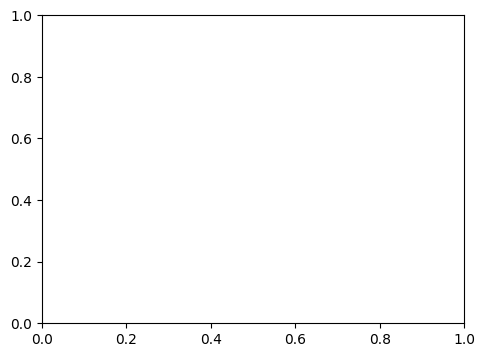

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()